In this notebook we will test whether Croissant recovers the sky temperature for some simple analytic beams with no horizon.

In [1]:
import croissant as cro

from astropy.units import s as seconds
import healpy
from lunarsky import Time
import matplotlib.pyplot as plt
import numpy as np

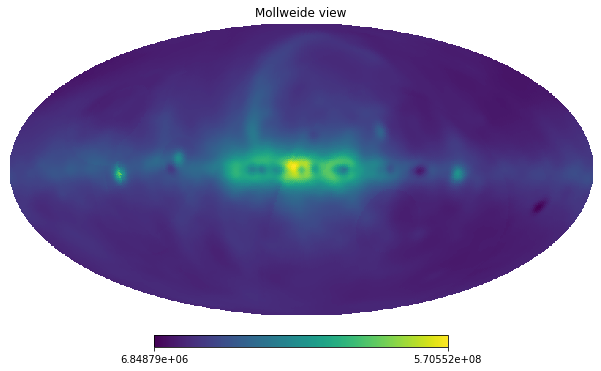

In [2]:
# 1 MHz resolution frequency
freq = np.linspace(1, 50, num=50)

sky = cro.sky.Sky.gsm(freq, power_law=True, gen_freq=25, spectral_index=-2.5)
healpy.mollview(sky.data[0])  # 1 MHz

## Uniform beam

In [3]:
# 1 deg spacing
theta = np.linspace(0, np.pi, num=181)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)

# uniform beam
power = np.ones((freq.size, theta.size, phi.size))

In [4]:
beam = cro.beam.Beam(power, theta=theta, phi=phi, frequencies=freq, coords="topocentric")

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model and extrpolate it by a power law to other frequencies.

In [5]:
# run the simulation on earth for one sidereal day
lmax = 32
loc = (37.87, 122.27, 0)
t_start = Time("2022-06-01 23:09:16")  # start time
t_end = t_start + cro.constants.sidereal_day_earth * seconds  # end time
horizon = np.ones_like(beam.data)  # this is the same as no horizon
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=300, t_end=t_end, moon=False, lmax=lmax, horizon=horizon
)

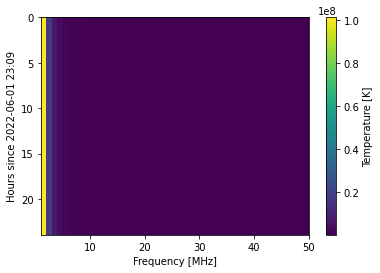

In [6]:
sim.run(dpss=False)
sim.plot()

With a uniform beam we should simply recover the mean sky temperature. In the language of spherical harmonics, the mean sky temperature is given by
$$<T_{\rm sky}> = a_{00} Y_0^0,$$ i.e. the (0,0)-mode of the spherical harmonics decomposition.

In [7]:
# there's no time dependence for the uniform beam
np.allclose(sim.waterfall, sim.waterfall[0])

True

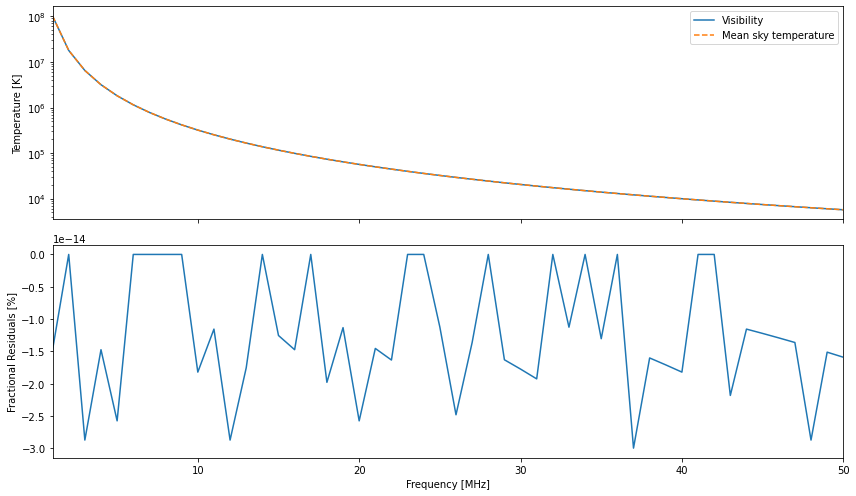

In [8]:
mean_sky = sim.sky[:, 0, 0].real * cro.constants.Y00  # a00 Y00

fig, axs = plt.subplots(figsize=(12, 7), nrows=2, sharex=True)
axs[0].plot(sim.frequencies, sim.waterfall[0], label="Visibility")
axs[0].plot(sky.frequencies, mean_sky, ls="--", label="Mean sky temperature")
axs[0].set_yscale("log")
axs[0].set_ylabel("Temperature [K]")
axs[0].legend()
axs[1].plot(sim.frequencies, (sim.waterfall[0] - mean_sky) / sim.waterfall[0] * 100)
axs[1].set_ylabel("Fractional Residuals [%]")
axs[1].set_xlabel("Frequency [MHz]")
plt.setp(axs, xlim=(sim.frequencies.min(), sim.frequencies.max()))
plt.tight_layout()
plt.show()

In [9]:
# we get the same result on the moon
t_end_moon = t_start + cro.constants.sidereal_day_moon * seconds
sim_moon = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=300, t_end=t_end_moon, moon=True, lmax=lmax, horizon=horizon
)
sim_moon.run(dpss=False)
np.allclose(sim.waterfall, sim_moon.waterfall)

True

## Dipole beam

The power of a dipole beam goes as
$$P \propto \nu^2 \cos^2{\theta}$$

In [10]:
power = (freq[:, None, None] * np.cos(theta)[None, :, None])**2
power = np.repeat(power, phi.size, axis=-1)  # no phi dependence
# we prepare the beams in equatorial coordinates so it is not rotated (i.e. it stays a perfect dipole in the sim)
beam = cro.beam.Beam(power, theta=theta, phi=phi, frequencies=freq, coords="equatorial")

In [11]:
# run the simulation with all the same parameters
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=300, t_end=t_end, moon=False, lmax=lmax, horizon=horizon
)

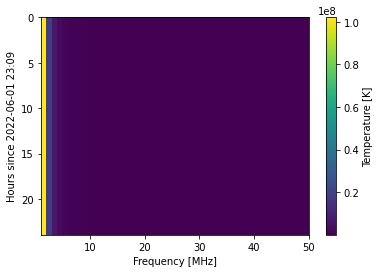

In [12]:
sim.run(dpss=False)
sim.plot()

A dipole beam should pick out the (0, 0) and (2, 0) modes of the sky. These are symmetric about the rotation axis of earth, hence there should be no time dependence.

In [13]:
np.allclose(sim.waterfall[0], sim.waterfall)  # no change with time

True

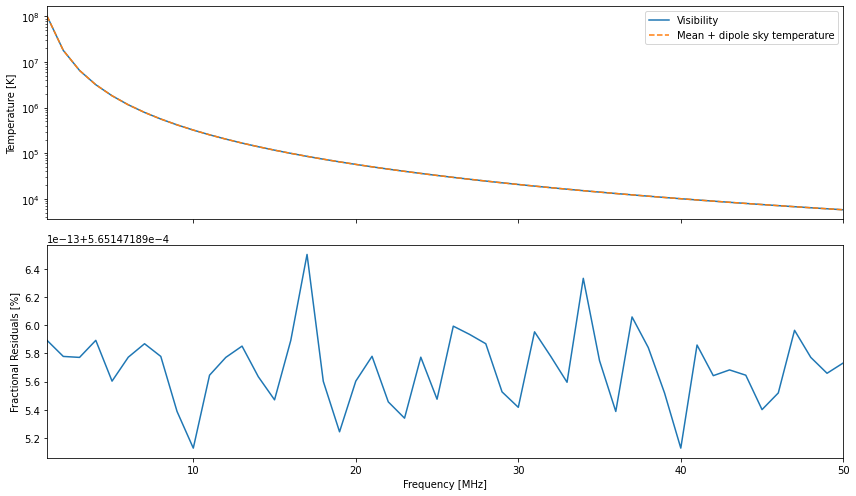

In [14]:
# the visibility is the mean sky temperature (as before) + the dipole contribution
dipole_sky = sim.sky[:, 2, 0].real * sim.beam.alm[:, 2].real  # perceived sky, dot product between sky and beam
dipole_sky /= sim.beam.alm[:, 0].real * cro.constants.Y00 * 4 * np.pi  # normalized by beam power

fig, axs = plt.subplots(figsize=(12, 7), nrows=2, sharex=True)
axs[0].plot(sim.frequencies, sim.waterfall[0], label="Visibility")
axs[0].plot(sky.frequencies, mean_sky + dipole_sky, ls="--", label="Mean + dipole sky temperature")
axs[0].set_yscale("log")
axs[0].set_ylabel("Temperature [K]")
axs[0].legend()
axs[1].plot(sim.frequencies, (sim.waterfall[0] - (mean_sky + dipole_sky)) / sim.waterfall[0] * 100)
axs[1].set_ylabel("Fractional Residuals [%]")
axs[1].set_xlabel("Frequency [MHz]")
plt.setp(axs, xlim=(sim.frequencies.min(), sim.frequencies.max()))
plt.tight_layout()
plt.show()

In [15]:
np.allclose(sim.waterfall[0], mean_sky + dipole_sky)

True